In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np, yaml, cPickle as pickle
from lib import data_io
import pandas as pd
from copy import copy
from sklearn.cross_validation import train_test_split

golden = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in richness labels and spectrograms and biotic predictions

In [4]:
richness = pd.read_csv(
    data_io.large_base + '../diversity_labelled_data/resultAndSiteFiles/6SitesWith90Minutes.csv')

richness_files = set(xx.split('.')[0] for xx in richness.File)

fname_to_richness = {}
for idx, row in richness.iterrows():
    
    fname_to_richness[row['File'].split('.')[0]] = sum(
        yy for xx, yy in row.iteritems() if xx != u'File')

In [5]:
# load in the spectrograms as computed
specs = {}
for fname in richness_files:
    specs[fname] = pickle.load(open('tmp/specs/' + fname +  '.pkl'))

In [6]:
# load in the predictions
preds = {}
for fname in richness_files:
    preds[fname] = pickle.load(open('tmp/preds/' + fname +  '_biotic.pkl'))

## Train test split by *site*

In [7]:
sites = list(set(xx.split('_')[0] for xx in richness_files))
test_sites = sites[0:1]
train_sites = sites[1:]

In [8]:
test_files = [xx for xx in richness_files if xx.split('_')[0] in test_sites]
train_files = [xx for xx in richness_files if xx.split('_')[0] in train_sites]

## Compute features from spectrograms

In [10]:
from lib.features import compute_all_feats

test_X = compute_all_feats(specs, test_files, preds)
train_X = compute_all_feats(specs, train_files, preds)

test_y = np.hstack(fname_to_richness[fname] for fname in test_files)
train_y = np.hstack(fname_to_richness[fname] for fname in train_files)

print train_X.shape, train_y.shape, test_X.shape, test_y.shape

(449, 33) (449,) (89, 33) (89,)


## Do machine learning

In [11]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(25, max_depth=25)
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)

/home/michael/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/home/michael/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


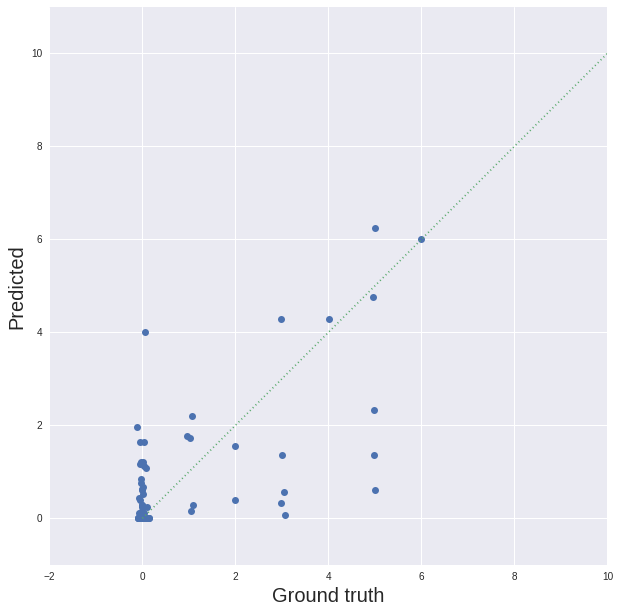

In [12]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plt.plot(test_y + np.random.randn(test_y.shape[0]) * 0.05 , pred_y, 'o')
plt.xlabel('Ground truth', fontsize=20)
plt.ylabel('Predicted', fontsize=20)
plt.axis('equal')
plt.plot([0, 10], [0, 10], ':')

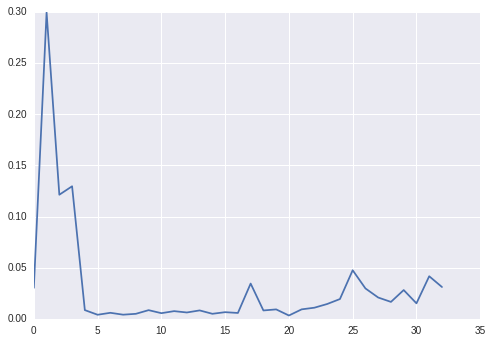

In [13]:
plt.plot(rf.feature_importances_)

## Do it again, but this time do for all sites

In [14]:
print np.bincount(train_y)

[302  46  31  21  13  14   9   3   7   1   2]


In [15]:
print idxs


NameError: name 'idxs' is not defined

In [18]:
all_preds = []
all_gt = []
pred_mapping = {}

for test_site in sites:
    test_sites = [test_site]
    train_sites = list(set(sites) - set(test_sites))

    test_files = [xx for xx in richness_files if xx.split('_')[0] in test_sites]
    train_files = [xx for xx in richness_files if xx.split('_')[0] in train_sites]

    # Compute features
    test_X = compute_all_feats(specs, test_files, preds)
    train_X = compute_all_feats(specs, train_files, preds)

    test_y = np.hstack(fname_to_richness[fname] for fname in test_files)
    train_y = np.hstack(fname_to_richness[fname] for fname in train_files)
    
    # Resample training classes
    if 1:
        max_cls_size = np.bincount(train_y).max()
        idxs = []
        for cls in np.unique(train_y):
            idxs.append(np.random.choice(np.where(train_y == cls)[0], max_cls_size))
        idxs = np.hstack(idxs)
        train_X = train_X[idxs]
        train_y = train_y[idxs]

    # Training and prediction
    rf = RandomForestRegressor(10, max_depth=15)
    rf.fit(train_X, train_y)
    pred_y = rf.predict(test_X)
    
    all_preds.append(pred_y)
    all_gt.append(test_y)
    
    for test_file, pred in zip(test_files, pred_y):
        pred_mapping[test_file] = pred

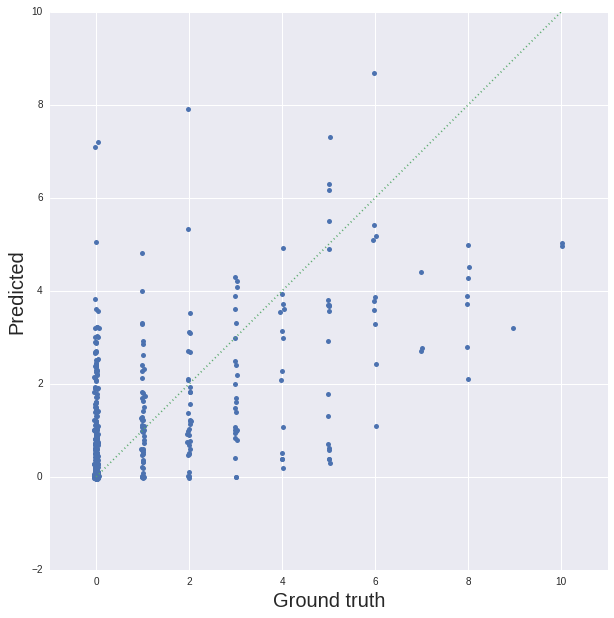

In [17]:
# plot for all
all_preds = np.hstack(all_preds)
all_gt = np.hstack(all_gt)

plt.figure(figsize=(10, 10))
plt.plot(all_gt + np.random.randn(all_gt.shape[0]) * 0.02 , 
         all_preds + np.random.randn(all_gt.shape[0]) * 0.02, 
         'o', markersize=5)
plt.xlabel('Ground truth', fontsize=20)
plt.ylabel('Predicted', fontsize=20)
plt.axis('equal')
plt.plot([0, 10], [0, 10], ':')


In [20]:
print len(pred_mapping)

538


## Do on all the golden set (must do differently...)

In [27]:
# Getting the list of golden files and seeing if we have predicted for them...
import os

base = '/media/michael/Engage/data/audio/alison_data//golden_set/'
spec_pkl_dir = base + 'extracted/specs/mel/'
golden_files = [xx.split('.')[0] for xx in os.listdir(spec_pkl_dir) if xx.endswith('.pkl')]

In [65]:
# Load in all the golden spectrograms
golden_specs = {fname: pickle.load(open('./tmp/specs/' + fname + '.pkl')) for fname in golden_files}
golden_preds = {fname: pickle.load(open('./tmp/preds/' + fname + '_biotic.pkl')) for fname in golden_files}

In [67]:
import collections
all_preds = []
all_gt = []
pred_mapping = collections.defaultdict(list)
failed = 0

for test_site in sites:
    test_sites = [test_site]
    train_sites = list(set(sites) - set(test_sites))

    test_files = [xx for xx in richness_files if xx.split('_')[0] in test_sites]
    train_files = [xx for xx in richness_files if xx.split('_')[0] in train_sites]

    # Compute features
    test_X = compute_all_feats(golden_specs, golden_files, golden_preds)
    train_X = compute_all_feats(specs, train_files, preds)

    train_y = np.hstack(fname_to_richness[fname] for fname in train_files)
    
    # Resample training classes
    if 1:
        max_cls_size = np.bincount(train_y).max()
        idxs = []
        for cls in np.unique(train_y):
            idxs.append(np.random.choice(np.where(train_y == cls)[0], max_cls_size))
        idxs = np.hstack(idxs)
        train_X = train_X[idxs]
        train_y = train_y[idxs]

    # Training and prediction
    rf = RandomForestRegressor(10, max_depth=15)
    rf.fit(train_X, train_y)
    pred_y = rf.predict(test_X)
    
    all_preds.append(pred_y)
    
    for test_file, pred in zip(golden_files, pred_y):
        
        # check not in the 
        if test_file not in train_files:
            pred_mapping[test_file].append(pred)
        else:
            failed += 1

print failed

30


In [72]:
pred_avgs = {fname: np.mean(vals) for fname, vals in pred_mapping.iteritems()}

print pred_avgs

{'BR28LB-11881_20150803_20300018': 0.31666666666666665, 'SE23-13527_20130907_1651': 1.0833333333333333, 'HA86RB-13527_20130730_0541': 1.5, 'E29RR-013378_20150530_07300012': 3.3666666666666667, 'W112NN-13548_20130709_1234': 0.8833333333333333, 'BR4-013378_20150820_22000018': 0.064129661672663887, 'E29RR-013378_20150526_08300012': 2.8000000000000003, 'BR67US-13534_20150801_12300024': 2.070207815863554, 'HA53AA-13548_20130730_0305': 0.23333333333333331, 'SE3-13548_20130911_0655': 0.033333333333333333, 'DA5-011881_20150827_1830007': 2.3666666666666667, 'E29RR-013378_20150530_03000023': 0.0, 'WC2H8LG-3527_20130715_1400': 3.6333333333333329, 'CR05EF-13527_20130921_1236': 0.9663793103448276, 'SW154LA-3527_20130705_0909': 2.2833333333333337, 'TW76ER-13534_20150626_02300015': 0.81666666666666676, 'CM167NP-3527_20150910_07300016': 4.1166666666666663, 'BR4-013378_20150825_0200003': 1.8666666666666665, 'BR28LB-11881_20150801_20300022': 0.29999999999999999, 'E29RR-013378_20150531_05300014': 3.08333

In [75]:
with open('./tmp/golden_richness_predictions.csv', 'w') as f:
    for fname, pred in pred_avgs.items():
        f.write('%s, %.2f\n' % (fname, pred))